# Local Hartree Calculations in Rhombohedral

## Presets

In [242]:
using Optics_in_the_length_gauge
using PhysicalConstants, LinearAlgebra
using PhysicalConstants.CODATA2018
using Unitful
using Statistics
using Roots
const kB = (PhysicalConstants.CODATA2018.k_B |> u"eV/K").val
# add https://github.com/fernandopenaranda/Optics_in_the_length_gauge
# units meV, fs, K

proj_folder = dirname(pwd())
rhomb_folder = proj_folder * "/model/rhombohedral/"
common_folder = proj_folder * "/comfunctions/"
figures_folder = proj_folder * "/Paper/Figures/"

include(rhomb_folder * "model.jl")
include(rhomb_folder * "observables.jl")
include(rhomb_folder * "plotters.jl")
include(rhomb_folder * "filling.jl")
include(rhomb_folder * "wrapper_lmc.jl")
include(rhomb_folder * "spontaneous_sym_breakingmodels.jl")
include(rhomb_folder * "local_hartree_optimization.jl")
include(common_folder * "separate_contributions.jl")

plotmap! (generic function with 1 method)

In [8]:
μlist = collect(0:0.01:10)
p = Params_rhombohedral(1, 0, 3160, 390,-20, 315, 0*44, 2, 0)
T = 2
B = 10
evals = 10000
N = 7
T = 2 #evals 80000 not perfect
τ = 200
η = 0.05

0.05

In [3]:
lmc_presets(N, μ,ξ, p::Params_rhombohedral; kws...) =  xxx_lmc_presets(N, μ, ξ, p; kws...)
lmcnoshift_presets(μ,ξ, evals) = xxx_lmc_presets(N, μ, ξ, p; evals = evals, T = T, berry_contribution = true, omm_contribution = true, fermi_surface = false, with_shift = false)
lmcshift_presets(μ,ξ) = xxx_lmc_presets(N, μ, ξ, p; evals = evals, T = T, fermi_surface = false, with_shift = true)

sigmaijkpresets = lmc_presets(5, 0,1, p);

## Calculations

### Create the interpolated quantities as a function of Ez

In [51]:
include(rhomb_folder * "local_hartree_optimization.jl")
estimated_bound_width = 10
evals = 1e5 # 1e5
η = 0.05 # 0.05
Ezlist = 0:0.1:10
# compute the interpolated functions passed to the optimization for each Ez in Ezlist
ϵ_mat, int_dos_mat, int_n_mat = interpolated_dos_ns_Ez(N, p, Ezlist, 
    estimated_bound_width = estimated_bound_width, evals = evals, η = η);

In [52]:
# using JLD2
# @save proj_folder * "/Paper/DATA/Interpolated_functions/N$(N)evals$(evals)eta$(η).jld" ϵ_mat int_dos_mat int_n_mat

In [53]:
@load proj_folder * "/Paper/DATA/Interpolated_functions/N$(N)evals$(evals)eta$(η).jld" ϵ_mat int_dos_mat int_n_mat

3-element Vector{Symbol}:
 :ϵ_mat
 :int_dos_mat
 :int_n_mat

In [10]:
# @load "/Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/Paper/DATA/Interpolated_functions/N7evals100000.0eta0.05.jld" ϵ_mat int_dos_mat int_n_mat

3-element Vector{Symbol}:
 :ϵ_mat
 :int_dos_mat
 :int_n_mat

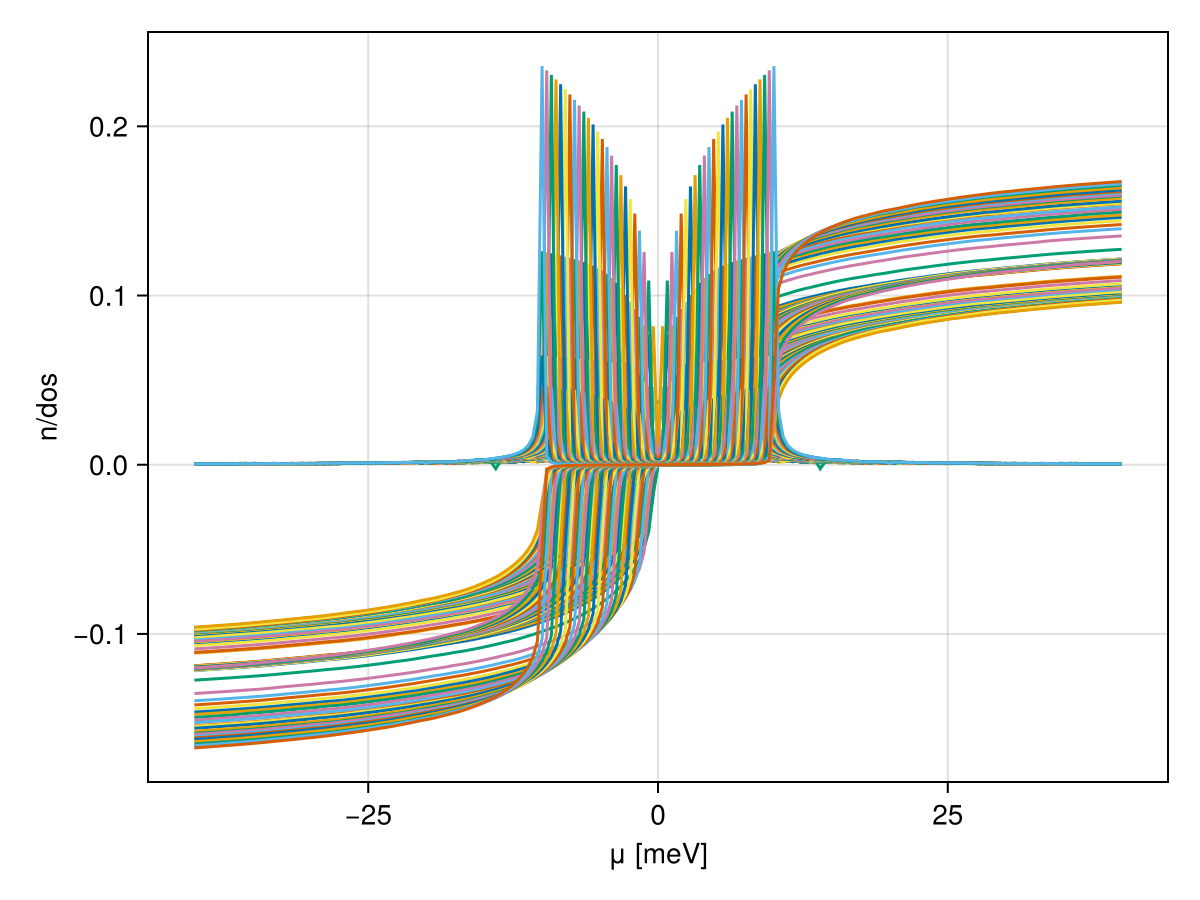

In [54]:
fig = Figure(); ax = Axis(fig[1,1], xlabel = "μ [meV]", ylabel = "n/dos")
# lines!(ax, ϵ_range, n.(ϵ_range))
for i in 1:length(ϵ_mat)
     lines!(ax, collect(ϵ_mat[i]), int_dos_mat[i].(collect(ϵ_mat[i])))
     lines!(ax, collect(ϵ_mat[i]), int_n_mat[i].(collect(ϵ_mat[i])))
end
fig

### Compute the occupations as a function of Ez

In [237]:
include(rhomb_folder * "local_hartree_optimization.jl")
U = + 10
J = - 10
νlist = collect(-0.15:0.01:0.15)
Ezlist = 0:0.1:10
@time μs, ns = Emin_nαs(int_dos_mat, int_n_mat, νlist, Ezlist; random_guesses = 10,
    U = U, J = J, λ = 1e4, η = 0.05, estimated_bound_width = 20, iterations = 10, int_model = :SU2);

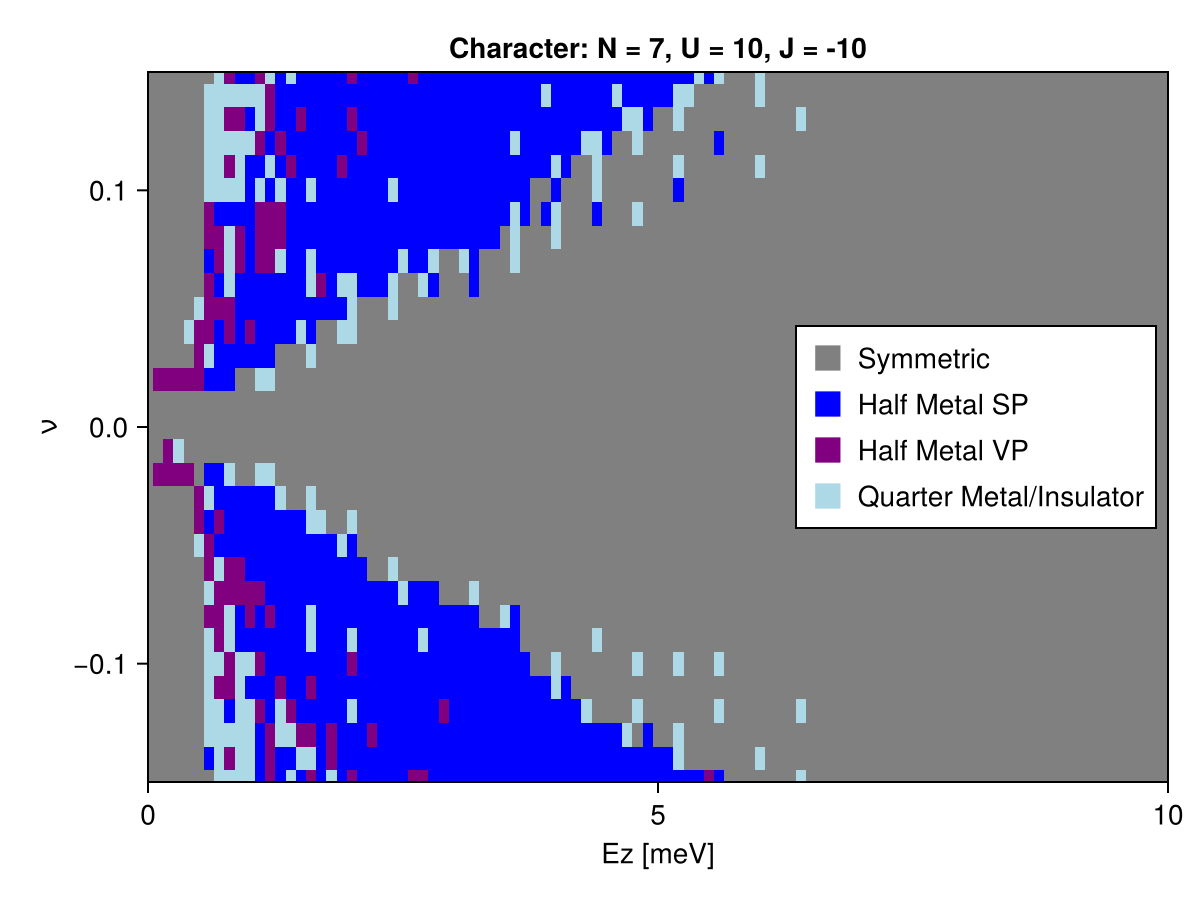

In [312]:
include(rhomb_folder * "local_hartree_optimization.jl")

function plot_characters(N, U, J, Ezlist, νlist, ns)
    characters = character(ns)
    xvect = νlist
    fig = Figure()
    ax= Axis(fig[1,1], xlabel = "Ez [meV]", ylabel = "ν", title = "Character: N = $(N), U = $(U), J = $(J)")

    scatter!(ax, [100], [100], color = :gray, label = "Symmetric", marker = :rect, markersize = 20)
    scatter!(ax, [100], [100], color = :blue, label = "Half Metal SP", marker = :rect, markersize = 20)
    scatter!(ax, [100], [100], color = :purple, label = "Half Metal VP", marker = :rect, markersize = 20)
    scatter!(ax, [100], [100], color = :lightblue, label = "Quarter Metal/Insulator", marker = :rect, markersize = 20)
    ylims!(ax, xvect[1], xvect[end])
    xlims!(ax, Ezlist[1], Ezlist[end])
    axislegend(ax, position = :rc)
    levels = [-1, 0, 1, 2]
    colors = [:purple, :gray, :blue, :lightblue]
    hm =  heatmap!(ax, Ezlist,  xvect, characters, colormap = colors, levels = levels, colorrange = [-1,2])#, rasterize = true)
    return fig
end

plot_characters(N, U, J, Ezlist, νlist, ns)

### Tests linecut

In [192]:
include(rhomb_folder * "local_hartree_optimization.jl")
U = 10
J = -5
μlist = collect(-10:.25:10)
@time nαs = Emin_nαs(int_dos_mat[4], int_n_mat[4], μlist; 
random_guesses = 10,
    U = U, J = J, λ = 1e5, η = 0.05, 
    estimated_bound_width = 10, iterations = 20, int_model = :SU4);

  3.364999 seconds (41.89 M allocations: 2.661 GiB, 11.76% gc time, 19.07% compilation time)


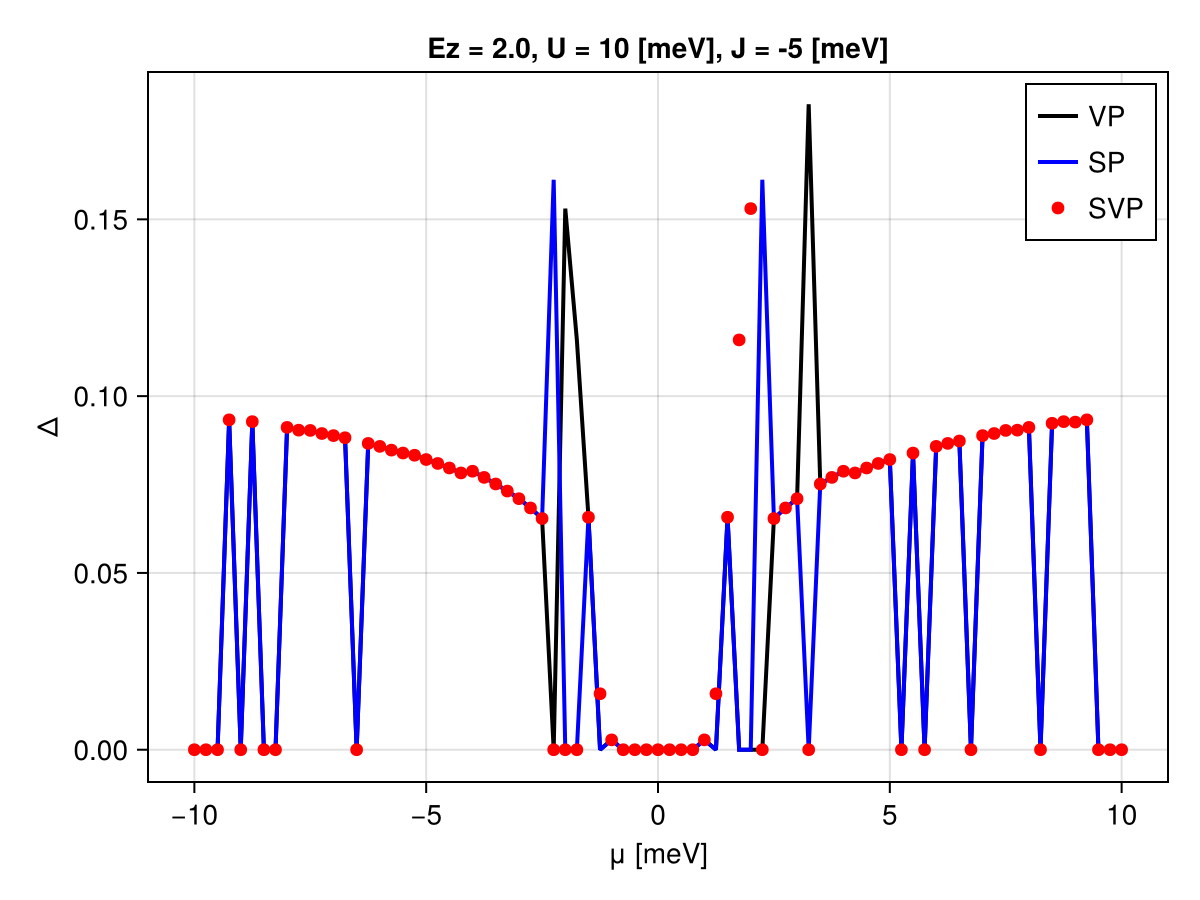

In [193]:
include(rhomb_folder * "local_hartree_optimization.jl")
fig = Figure(); ax = Axis(fig[1,1], xlabel = "μ [meV]", ylabel = "Δ", title = "Ez = $(p.Delta_Ez), U = $(U) [meV], J = $(J) [meV]")
lines!(ax, μlist, [polarization(nαs[i])[1] for i in 1:length(nαs)], label = "VP", color = "black", linewidth = 2)
lines!(ax, μlist, [polarization(nαs[i])[2] for i in 1:length(nαs)], label = "SP", color = :blue, linewidth = 2)
scatter!(ax, μlist, [polarization(nαs[i])[3] for i in 1:length(nαs)], label = "SVP", color = :red, linewidth = 2)
# ylims!(ax, [-0.1,2.1])
# scatter!(ax, μlist,[rh_order_parameter(nαs[i])[3] for i in 1:length(nαs)], label = "1-3", color = :purple, markersize = 6)
axislegend(ax)
fig

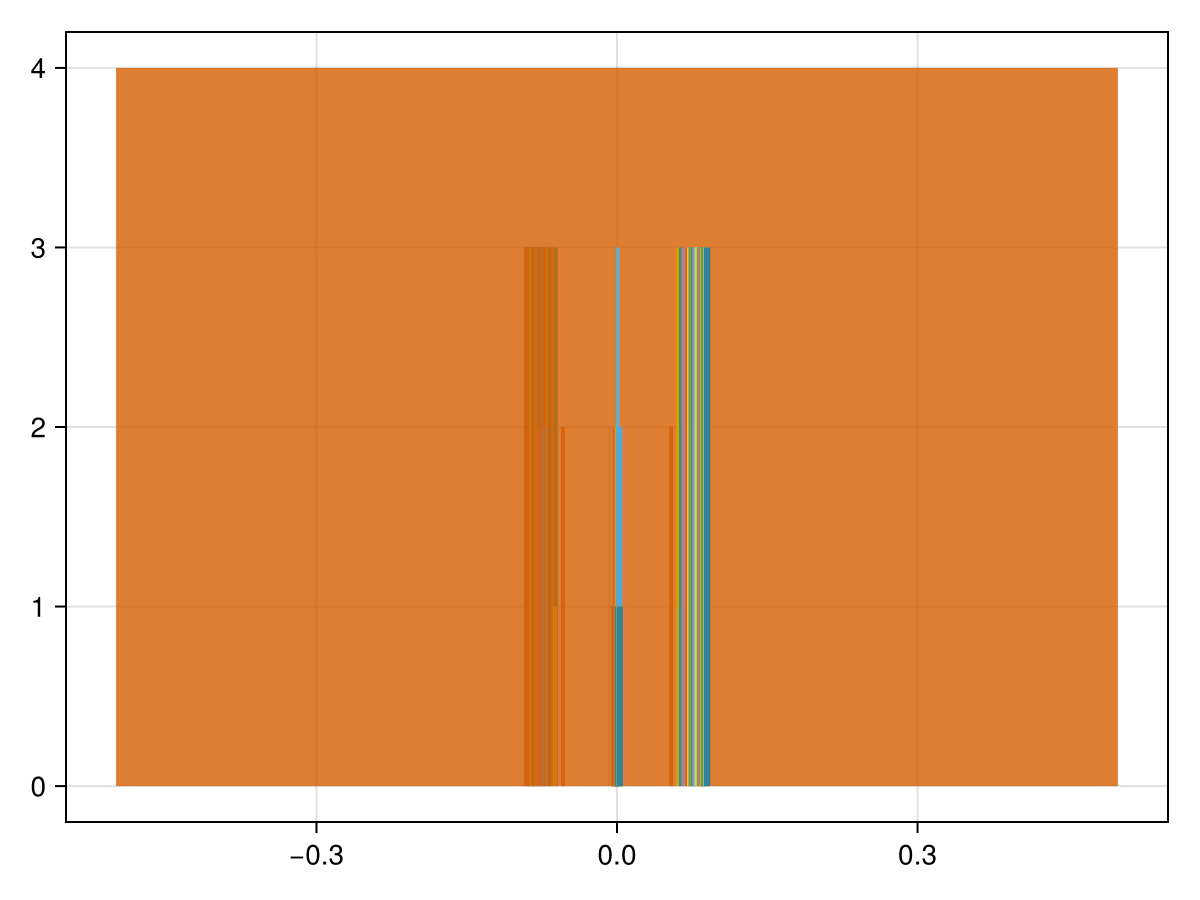

In [209]:
fig = Figure()
dim = length(nαs)
ax = Axis(fig[1,1])
for i in 1:dim
     hist!(ax, nαs[i])
end
fig

In [210]:
nαs[1]

4-element Vector{Float64}:
 -0.07984762405987866
 -0.07984762406083563
 -0.07984762405823821
 -0.07984762405893955

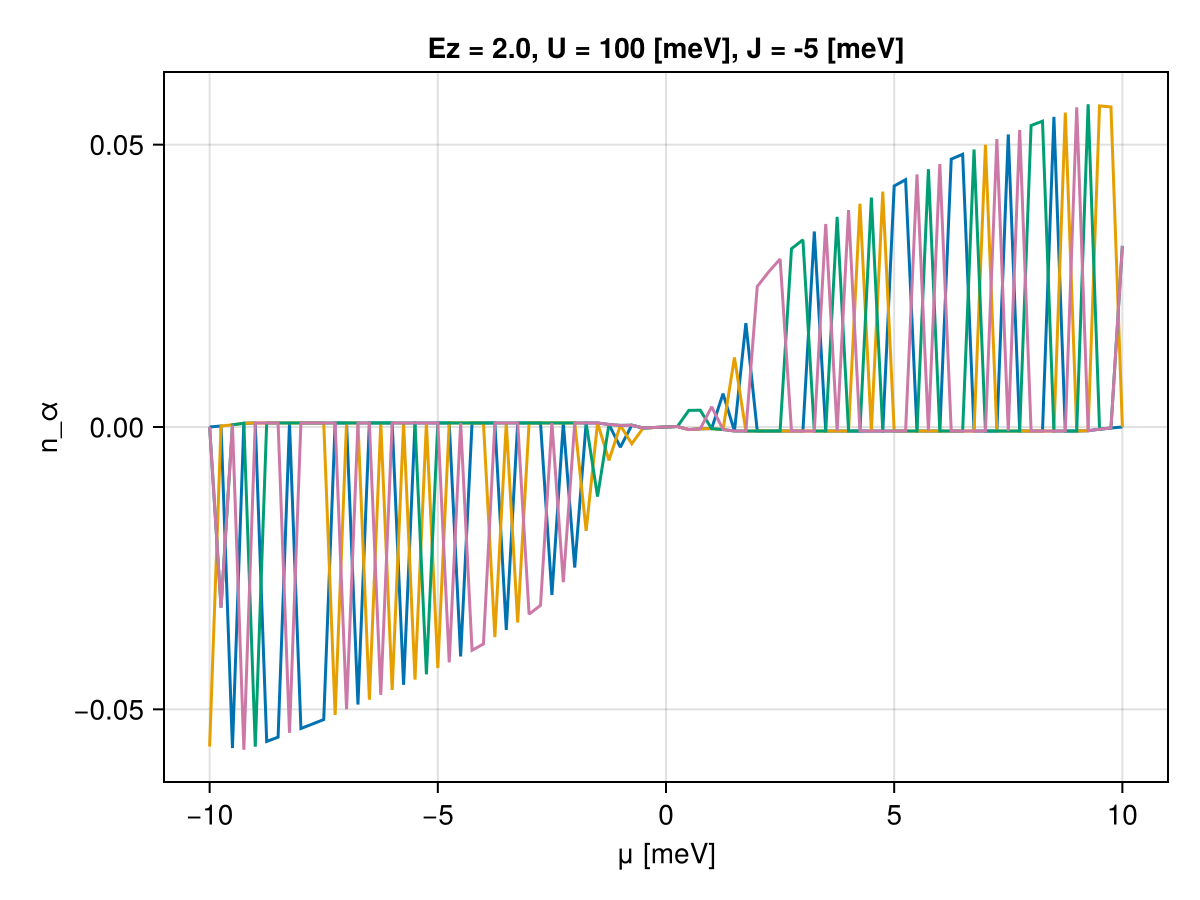

In [191]:
fig = Figure(); ax = Axis(fig[1,1], xlabel = "μ [meV]", ylabel = "n_α", title = "Ez = $(p.Delta_Ez), U = $(U) [meV], J = $(J) [meV]")
lines!(ax, μlist, [nαs[i][1] for i in 1:length(nαs)], label = "K↑")
lines!(ax, μlist, [nαs[i][2] for i in 1:length(nαs)], label = "K'↑")
lines!(ax, μlist,[nαs[i][3] for i in 1:length(nαs)], label = "K↓")
lines!(ax, μlist, [nαs[i][4] for i in 1:length(nαs)], label = "K'↓")
fig

In [47]:
ind = 49
println(nαs[ind])
polarization(nαs[ind])


[-0.05514671156056664, -0.05514671156060637, 0.05544728180334498, 0.05544728180334498]


(3.5919691188200456e-13, 1.9999926137079012, 3.5919691188200456e-13)

### Bands of the spinfull model with local Hartree

In [313]:
function spinfull_plotbandsanddos(N, p, nαs, μαs, Ez, μlist; points = 100, evals = 100, η = 0.05)

    ps =[Params_rhombohedral(p, μ = μαs[1], ξ = 1, Delta_Ez = Ez, Valley_asym = 0),
    Params_rhombohedral(p, μ = μαs[2], ξ = -1, Delta_Ez = Ez, Valley_asym = 0),
    Params_rhombohedral(p, μ = μαs[3], ξ = 1, Delta_Ez = Ez, Valley_asym = 0),
    Params_rhombohedral(p, μ = μαs[4], ξ = -1, Delta_Ez = Ez, Valley_asym = 0)]

    
        fig = Figure()
        ax = Axis(fig[1, 1]; xlabel = "kx", ylabel = "E [meV]", title = "N = $(N), ν = $(round(sum(nαs),digits = 2)), Ez = $(Ez)")
        spinfull_plotbands!(ax, N, p, μαs, Ez, points = points)
    
        ax2 = Axis(fig[1,2], xlabel = "μ [meV]", ylabel = "DOS (a.u.)", title = "ν = $(round(sum(nαs),digits = 2)), Ez = $(Ez)")

    abcNplotbandsk(ax, N, points, ps[1]; ylims = [-1, 1])#, style = :solid)
    abcNplotbandsk(ax, N, points, ps[2]; ylims = [-1, 1])#, style = :dash)
    abcNplotbandsk(ax, N, points, ps[3]; ylims = [-1, 1])#, style = :solid)
    abcNplotbandsk(ax, N, points, ps[4]; ylims = [-1, 1])#, style = :dash)

    ω, js = spinfull_dos(N, ps, η, evals, μlist)
    plot_dos!(ax2, ω, js)
    fig
end


function spinfull_plotbands(N, p, nαs, μαs, Ez; points = 100)
    fig = Figure()
    ax = Axis(fig[1:2, 0]; xlabel = "kx", ylabel = "E [meV]", title = "N = $(N), ν = $(round(sum(nαs),digits = 2)), Ez = $(Ez)")
    spinfull_plotbands!(ax, N, p, μαs, Ez, points = points)
    return fig
end
"""
Now 1 → K↑, 2 → K'↑, 3 → K↓, 4 → K'↓.
"""
function spinfull_plotbands!(ax, N, p, μαs, Ez; points = 100)
    ps =[Params_rhombohedral(p, μ = μαs[1], ξ = 1, Delta_Ez = Ez, Valley_asym = 0),
        Params_rhombohedral(p, μ = μαs[2], ξ = -1, Delta_Ez = Ez, Valley_asym = 0),
        Params_rhombohedral(p, μ = μαs[3], ξ = 1, Delta_Ez = Ez, Valley_asym = 0),
        Params_rhombohedral(p, μ = μαs[4], ξ = -1, Delta_Ez = Ez, Valley_asym = 0)]

    abcNplotbandsk(ax, N, points, ps[1]; ylims = [-1, 1])#, style = :solid)
    abcNplotbandsk(ax, N, points, ps[2]; ylims = [-1, 1])#, style = :dash)
    abcNplotbandsk(ax, N, points, ps[3]; ylims = [-1, 1])#, style = :solid)
    abcNplotbandsk(ax, N, points, ps[4]; ylims = [-1, 1])#, style = :dash)
end

function spinfull_dos(N, p, ns, μαs, Ez; evals = 100, η = 0.05)

    ps =[Params_rhombohedral(p, μ = μαs[1], ξ = 1, Delta_Ez = Ez, Valley_asym = 0),
        Params_rhombohedral(p, μ = μαs[2], ξ = -1, Delta_Ez = Ez, Valley_asym = 0),
        Params_rhombohedral(p, μ = μαs[3], ξ = 1, Delta_Ez = Ez, Valley_asym = 0),
        Params_rhombohedral(p, μ = μαs[4], ξ = -1, Delta_Ez = Ez, Valley_asym = 0)]

    ω, js = spinfull_dos(N, ps, η, evals)
    fig = Figure()
    ax = Axis(fig[1,1], xlabel = "μ [meV]", ylabel = "DOS (a.u.)", title = "ν = $(round(sum(ns),digits = 2)), Ez = $(Ez)")
    plot_dos!(ax, ω, js)
    fig
end

function spinfull_dos(N, ps, η, evals, μlist)
    nps = [xxx_lmc_presets(N, ps[i]) for i in 1:length(ps)]
    ω, j1 = c_dos(nps[1], μlist, η = η, evals = evals)
    ω, j2 = c_dos(nps[2], μlist, η = η, evals = evals)
    ω, j3 = c_dos(nps[3], μlist, η = η, evals = evals)
    ω, j4 = c_dos(nps[4], μlist, η = η, evals = evals)
    return ω, [j1,j2,j3,j4]
end

function plot_dos!(ax, ω, js)
    colors = [:black, :black, :gray, :gray]
    styles = [:solid, :dash, :solid, :dash]
    labels = ["K↑", "K'↑", "K↓","K'↓"]
    for (i,j) in enumerate(js)
        lines!(ax, ω, j, color = colors[i], linestyle = styles[i], label = labels[i])
    end
    axislegend(ax)
end

plot_dos! (generic function with 1 method)

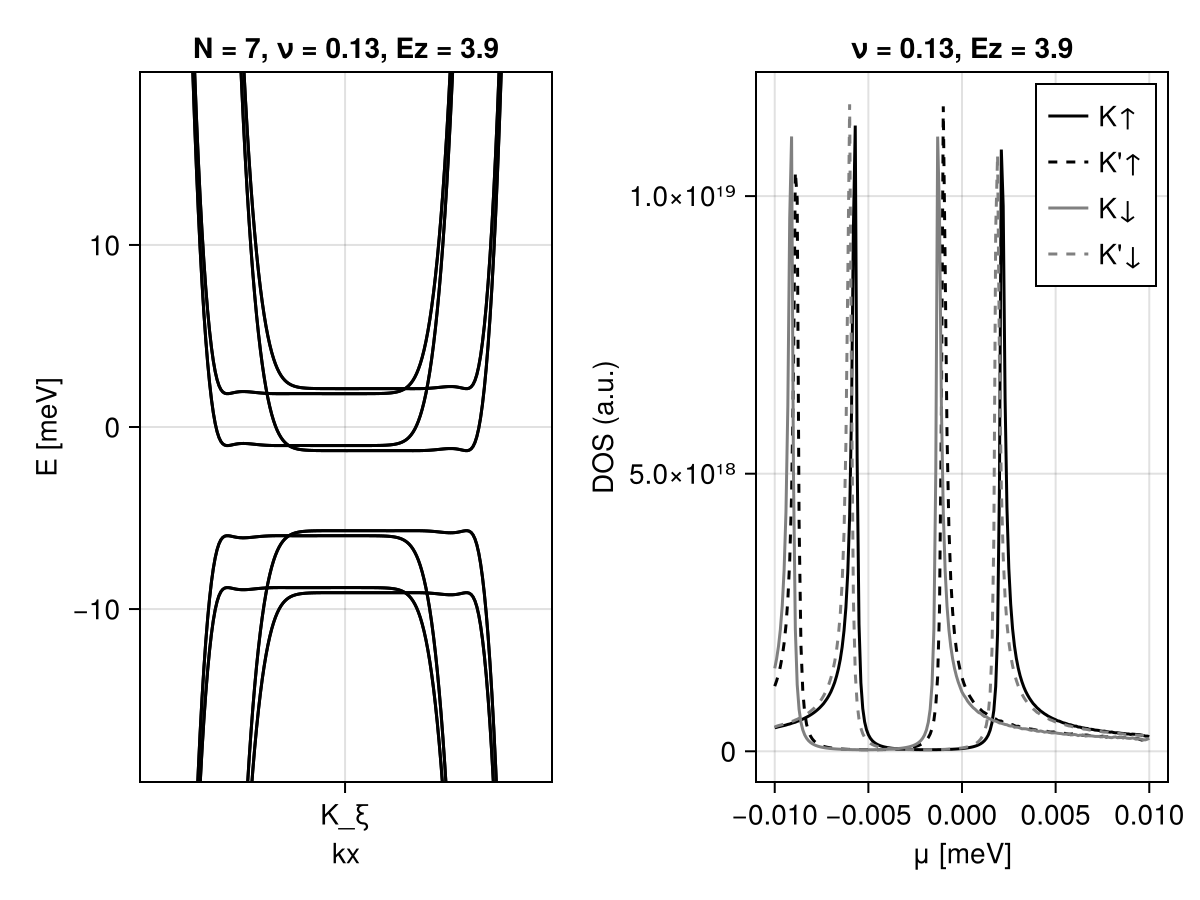

In [314]:
# 10 seconds
Ez_ind = 40 
μ_ind = 30 #
spinfull_plotbandsanddos(N, p, ns[Ez_ind][μ_ind], μs[Ez_ind][μ_ind], Ezlist[Ez_ind], collect(-10:0.1:10); points = 100, evals = 1e5, η = 0.1)

In [ ]:
# spinfull_dos(N, p, ns[Ez_ind][μ_ind], μs[Ez_ind][μ_ind], 3*Ezlist[Ez_ind]; evals = 1e3, η = 0.05)

In [ ]:
# Ez_ind = 15
# μ_ind = 2
# μs[ind1][ind2] 
# spinfull_plotbands(N, p, ns[Ez_ind][μ_ind], μs[Ez_ind][μ_ind], Ezlist[Ez_ind] ; points = 100)

## Optical observables

In [350]:
#_________________________________________________________________________________________
# LMC
#_________________________________________________________________________________________
"""
function observable functions are defined for each flavour so you have to sum
the four of them to get the experimental value
"""
function lc_map(N, p::Params_rhombohedral, Ezlist, νlist, μαs; kws...)
    μs = reshape_densities(μαs)
    dimx = size(μs[1],1)
    dimy = size(μs[1],2)
    lmcs = zeros(Float64, dimx, dimy)
    # presets0 =  xxx_lmc_presets(N,Params_rhombohedral(p, μ = μs[1][2,3], Delta_Ez = 0); kws...)
    # presets0.computation
    # println(presets0.computation.evals)
    for (i,Ez) in enumerate(Ezlist)
        for (j, ν) in enumerate(νlist)
            lmcs[i,j] = sum([linear_magneto_conductivity(
                xxx_lmc_presets(N, 
                Params_rhombohedral(p, μ = μs[k][i,j], Delta_Ez = Ez); kws...)
            ) for k in 1:4])
        end
    end
    return lmcs
end

function plot_lmc(N, U, J, Ezlist, νlist, lmc)
    fig = Figure(size = (500,500))
    ax= Axis(fig[1,1], xlabel = "Ez [meV]", ylabel = "ν", title = "Character: N = $(N), U = $(U), J = $(J)")
    ylims!(ax,  νlist[1], νlist[end])
    xlims!(ax, Ezlist[1], Ezlist[end])
    colors = :inferno
    hm =  heatmap!(ax, Ezlist,  νlist, lmc, colormap = colors, levels = levels)#, colorrange = [-1,2])#, rasterize = true)
    cb = Colorbar(fig[1,2], hm, label = "σxxx [1/T*e²/h]")
    return fig
end

#_________________________________________________________________________________________
# Drude
#_________________________________________________________________________________________
function drude_map()
    nothing
end

#_________________________________________________________________________________________
# AHE
#_________________________________________________________________________________________
function ahe_map()
    nothing
end




ahe_map (generic function with 1 method)

In [351]:
lmcs = lc_map(N, p, Ezlist, νlist, μs, evals = 0)

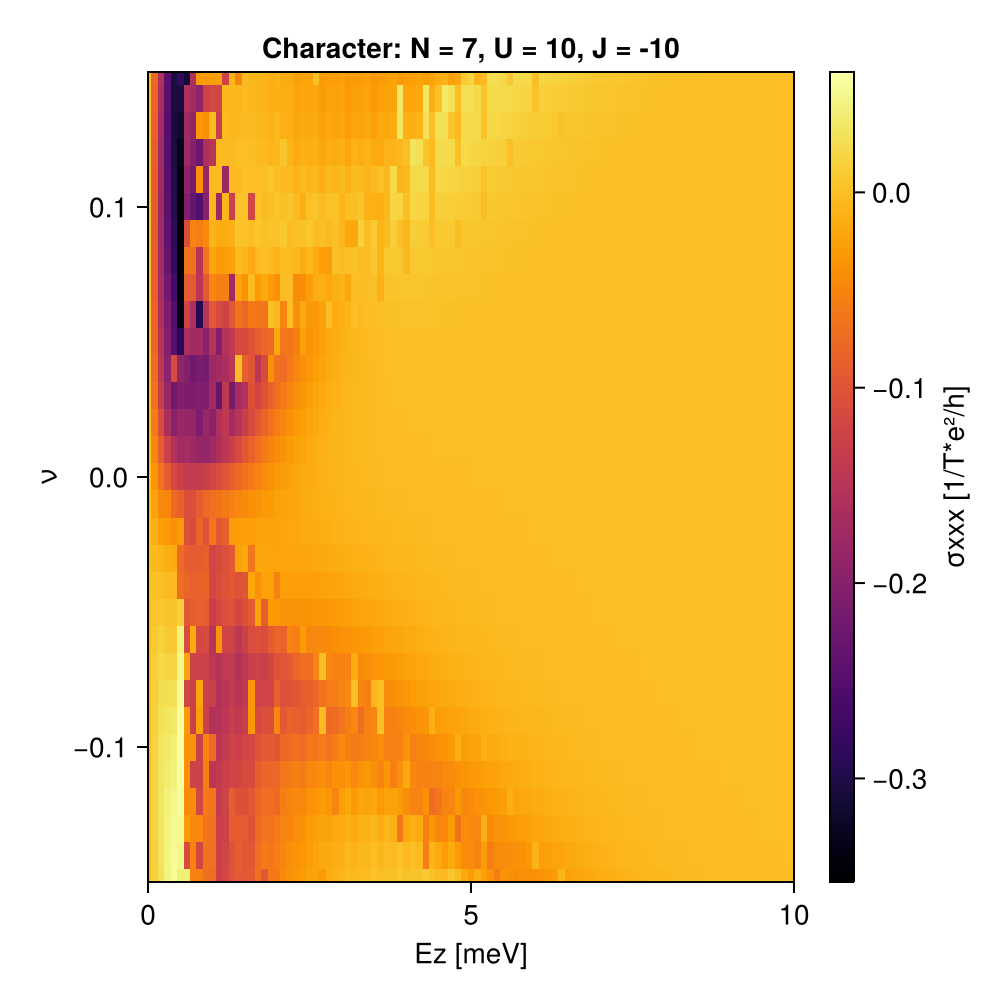

In [333]:
plot_lmc(N, U, J, Ezlist, νlist, lmcs)

In [ ]:
evals = 80000
μlist = collect(0:.1:15)
T = 5
N = 3





xx_drude_presets(N, μ,ξ, evals) = 
    xx_drude_presets(N, μ, ξ, p; evals = evals, T = T)
lmcnoshift_presets(N, μ, ξ, evals) = xxx_lmc_presets(N, μ, ξ, p; evals = evals,
    T = T, τ = τ, berry_contribution = true, omm_contribution = true, 
    fermi_surface = false, with_shift = false)

lmcpv = [linear_magneto_conductivity(lmcnoshift_presets(N, μ, 1, evals))
     for μ in μlist];
# lmcnv = [linear_magneto_conductivity(lmcnoshift_presets(N, μ, -1, evals))
#      for μ in μlist];
drudepv = [drude_conductivity(xx_drude_presets(N, μ, 1, evals)) for μ in μlist];

μ = 0
ξ = -1
T = 0.5
N = 7
evals = 1000
μlist = collect(-10:0.2:10)

ahe_p(μ, ξ) = σxyahe_presets(N, μ, ξ, p, evals = evals, T = T)
ahe_pos = [σij_anomalous_hall(ahe_p(μ, 1)) for μ in μlist];
ahe_neg = [σij_anomalous_hall(ahe_p(μ, -1)) for μ in μlist];